In [1]:
# Install yfinance if not already installed
!pip install yfinance

# Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# List of stocks you want to analyze
stocks = ['AAPL', 'AMZN', 'GOOGL', 'TSLA']

# Download 2 years of 1-hour interval data for all stocks
data = yf.download(
    stocks,
    period='2y',        # Last 2 years
    interval='1h',      # 1-hour candles
    group_by='ticker'   # Group data stock-wise
)

# Show downloaded data structure
print(data.keys())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

MultiIndex([( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume'),
            ('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AMZN',   'Open'),
            ( 'AMZN',   'High'),
            ( 'AMZN',    'Low'),
            ( 'AMZN',  'Close'),
            ( 'AMZN', 'Volume'),
            ( 'TSLA',   'Open'),
            ( 'TSLA',   'High'),
            ( 'TSLA',    'Low'),
            ( 'TSLA',  'Close'),
            ( 'TSLA', 'Volume')],
           names=['Ticker', 'Price'])


In [3]:
# Function to generate Buy/Sell signals based on Moving Average Crossover
def generate_signals(df, short_window=10, long_window=50):
    # Calculate Short and Long Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

    # Lists to hold signals
    buy_signals = []
    sell_signals = []
    position = False  # False = No holdings, True = Holding stock

    for i in range(len(df)):
        if df['SMA_Short'].iloc[i] > df['SMA_Long'].iloc[i]:  # Buy Condition
            if not position:
                buy_signals.append(df['Close'].iloc[i])
                sell_signals.append(np.nan)
                position = True
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        elif df['SMA_Short'].iloc[i] < df['SMA_Long'].iloc[i]:  # Sell Condition
            if position:
                sell_signals.append(df['Close'].iloc[i])
                buy_signals.append(np.nan)
                position = False
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    # Save signals to DataFrame
    df['Buy'] = buy_signals
    df['Sell'] = sell_signals
    return df


In [5]:
# Trading settings
initial_balance = 10000
transaction_fee_rate = 0.001
stop_loss_pct = 0.05
take_profit_pct = 0.10

# New dictionary to store processed stocks
stock_data = {}

# Process each stock separately
for stock in stocks:
    print(f"\nProcessing {stock}...")

    stock_df = data[stock].copy()
    stock_df = generate_signals(stock_df)

    balance = initial_balance
    holdings = 0
    buy_price = 0
    portfolio_values = []

    for i in range(len(stock_df)):
        price = stock_df['Close'].iloc[i]

        # No holdings: look for buy
        if holdings == 0:
            if not np.isnan(stock_df['Buy'].iloc[i]):
                num_shares_to_buy = balance // (price * (1 + transaction_fee_rate))
                cost = num_shares_to_buy * price * (1 + transaction_fee_rate)
                if num_shares_to_buy > 0:
                    balance -= cost
                    holdings += num_shares_to_buy
                    buy_price = price

        # Holdings exist: look for sell, stop-loss, take-profit
        else:
            if not np.isnan(stock_df['Sell'].iloc[i]):
                proceeds = holdings * price * (1 - transaction_fee_rate)
                balance += proceeds
                holdings = 0
                buy_price = 0
            elif buy_price > 0:
                loss_threshold = buy_price * (1 - stop_loss_pct)
                profit_threshold = buy_price * (1 + take_profit_pct)

                if price <= loss_threshold or price >= profit_threshold:
                    proceeds = holdings * price * (1 - transaction_fee_rate)
                    balance += proceeds
                    holdings = 0
                    buy_price = 0

        # Track portfolio value
        total_value = balance + (holdings * price)
        portfolio_values.append(total_value)

    # Save portfolio value to dataframe
    stock_df['Portfolio Value'] = portfolio_values

    # Save into new stock_data dictionary
    stock_data[stock] = stock_df



Processing AAPL...

Processing AMZN...

Processing GOOGL...

Processing TSLA...


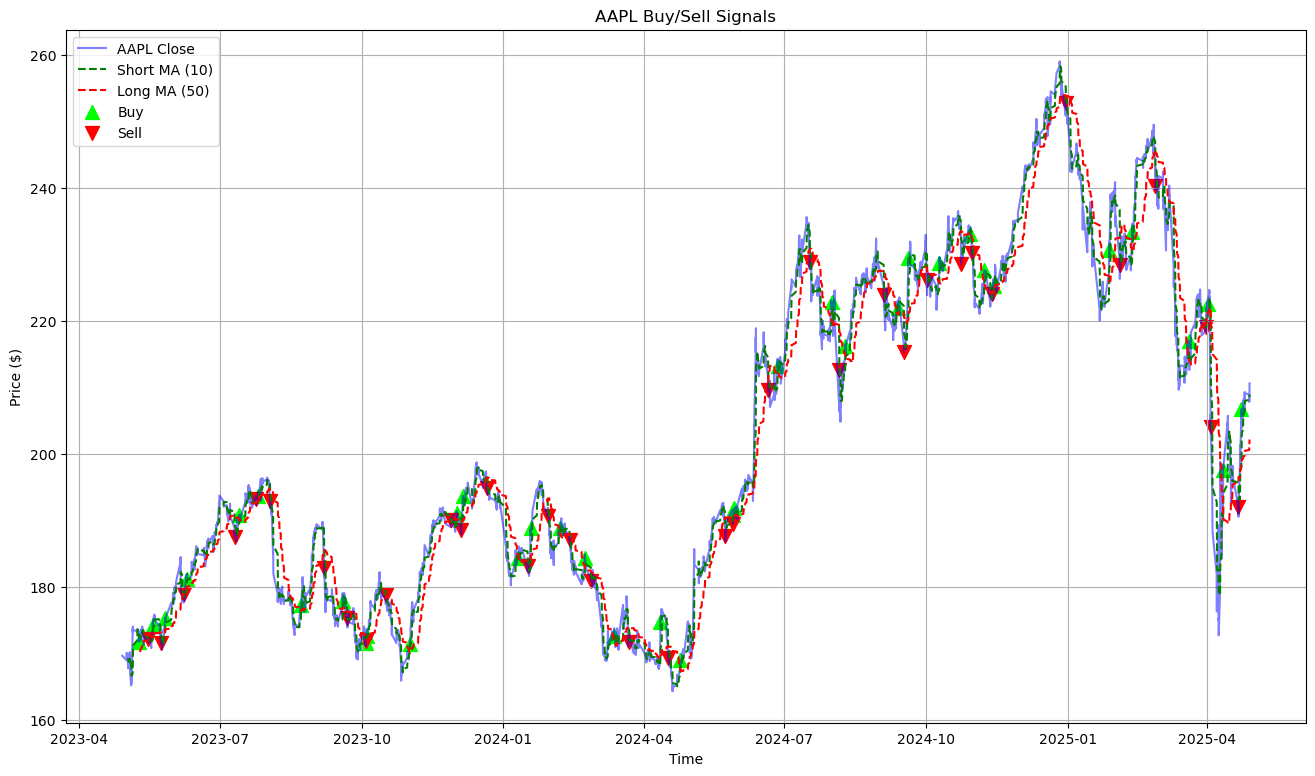

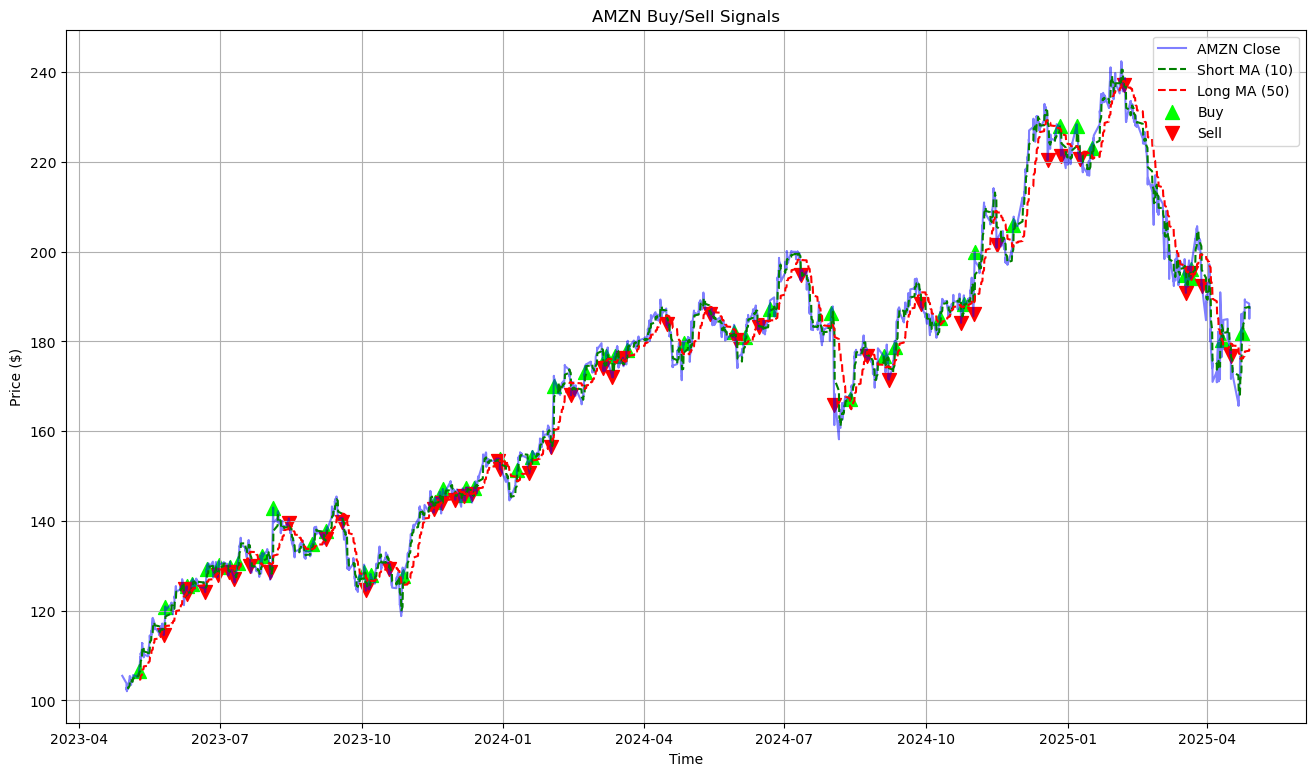

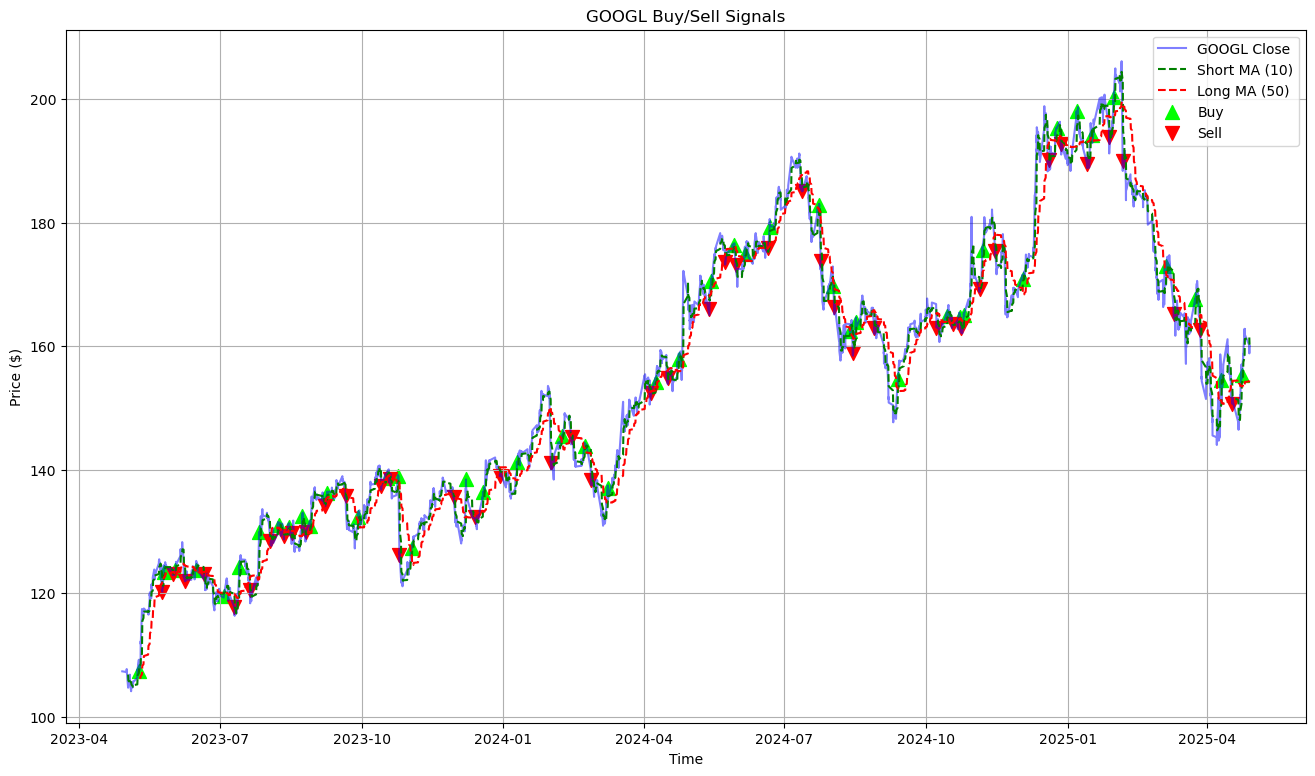

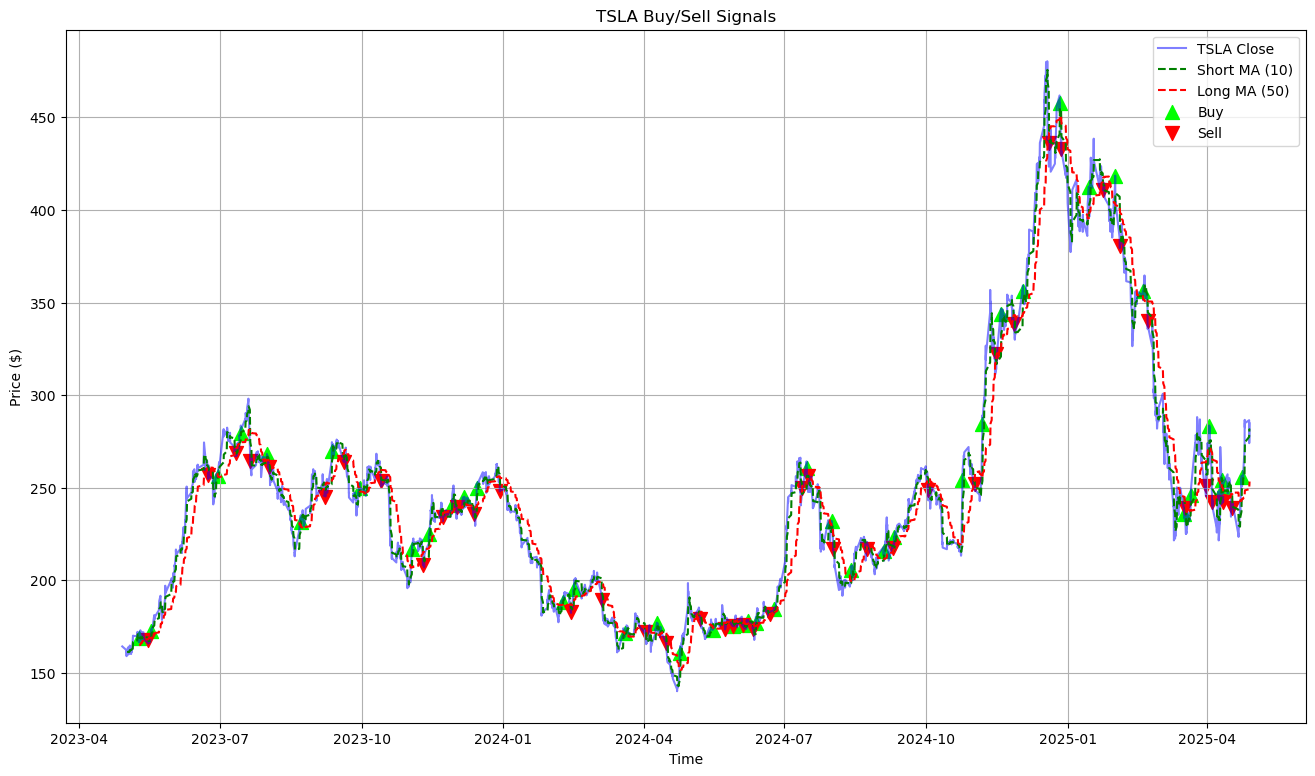

In [6]:
# Plotting everything
for stock in stocks:
    stock_df = stock_data[stock]

    # Price Chart with Buy/Sell
    plt.figure(figsize=(16,9))
    plt.plot(stock_df['Close'], label=f'{stock} Close', color='blue', alpha=0.5)
    plt.plot(stock_df['SMA_Short'], label='Short MA (10)', color='green', linestyle='--')
    plt.plot(stock_df['SMA_Long'], label='Long MA (50)', color='red', linestyle='--')
    plt.scatter(stock_df.index, stock_df['Buy'], label='Buy', marker='^', color='lime', s=100)
    plt.scatter(stock_df.index, stock_df['Sell'], label='Sell', marker='v', color='red', s=100)
    plt.title(f'{stock} Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid()
    plt.show()


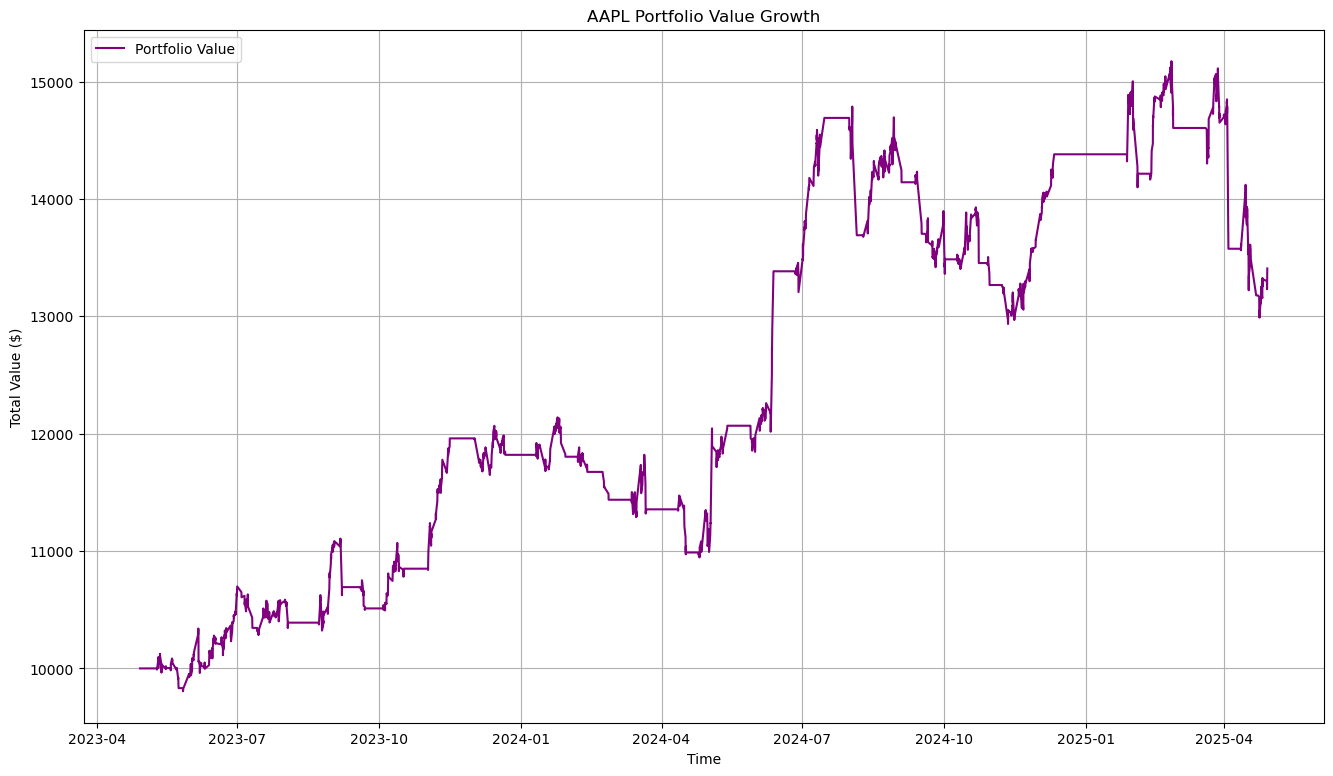

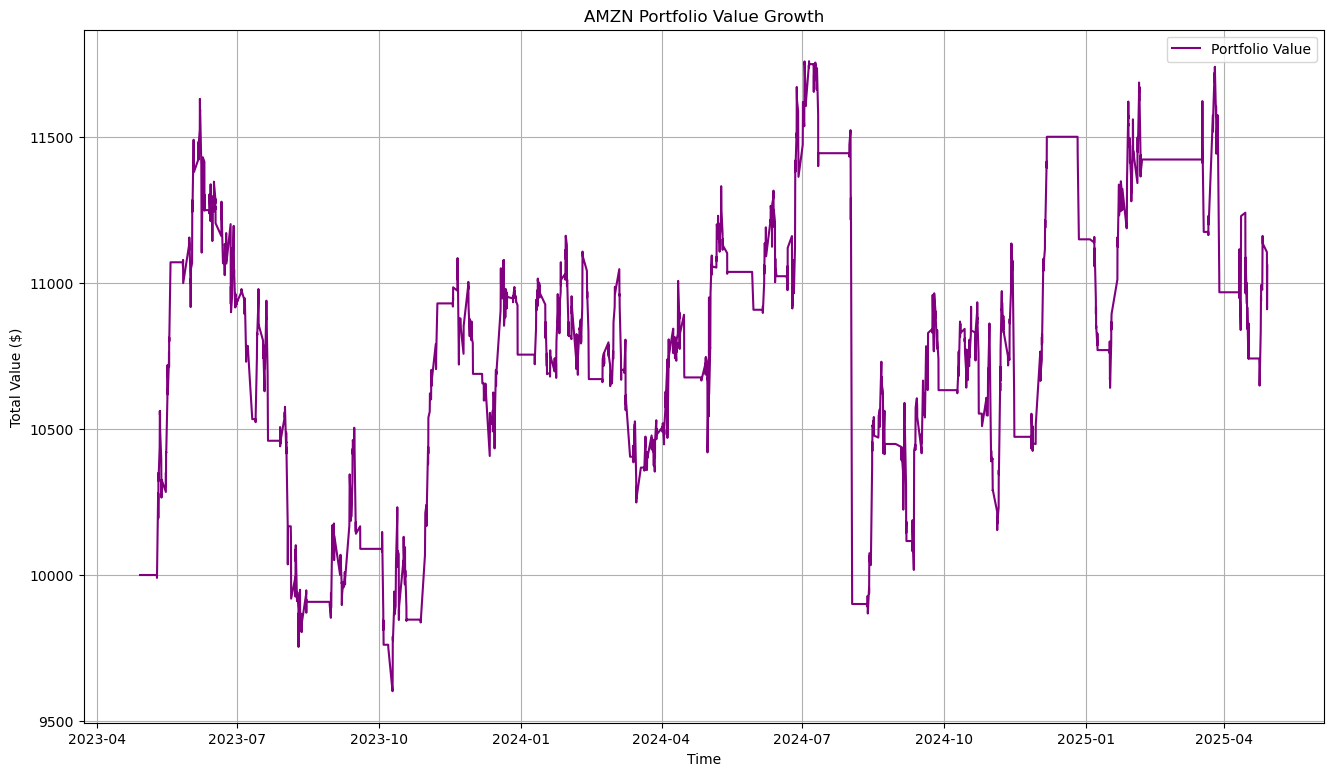

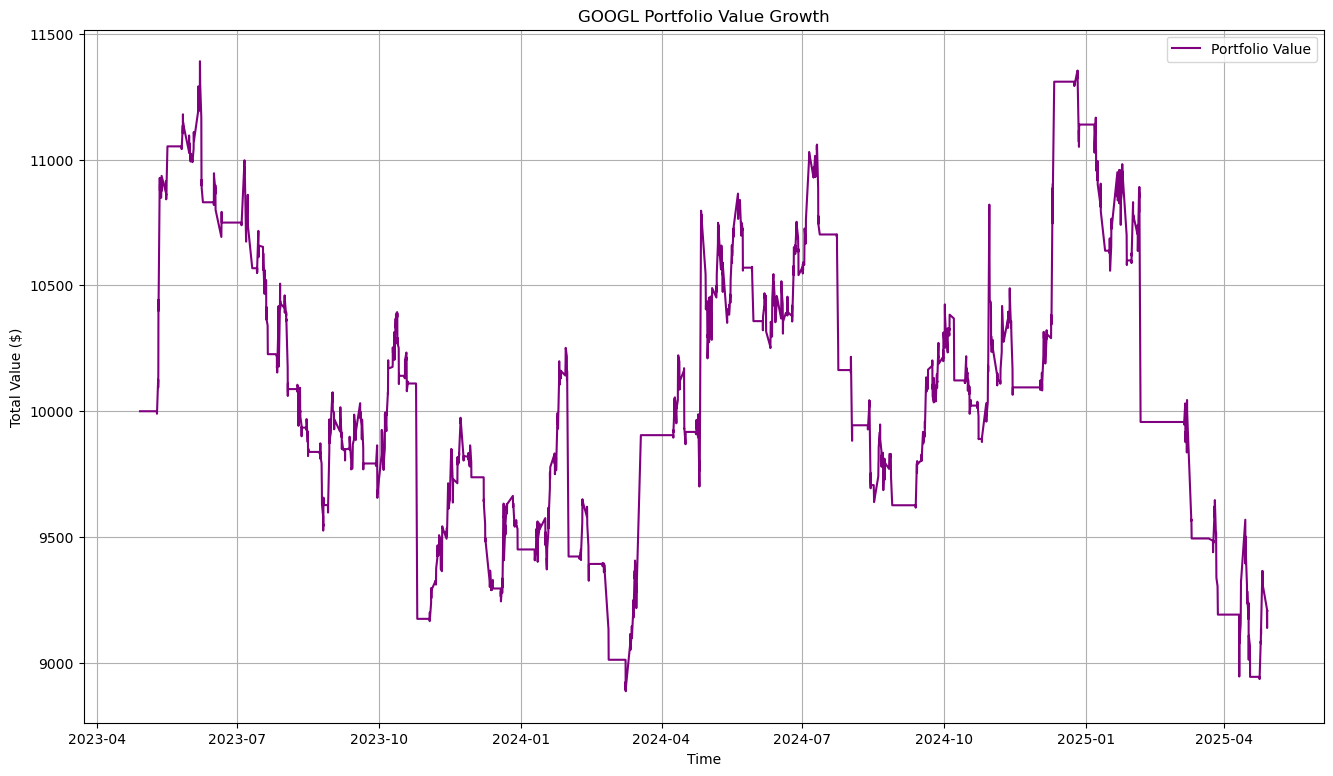

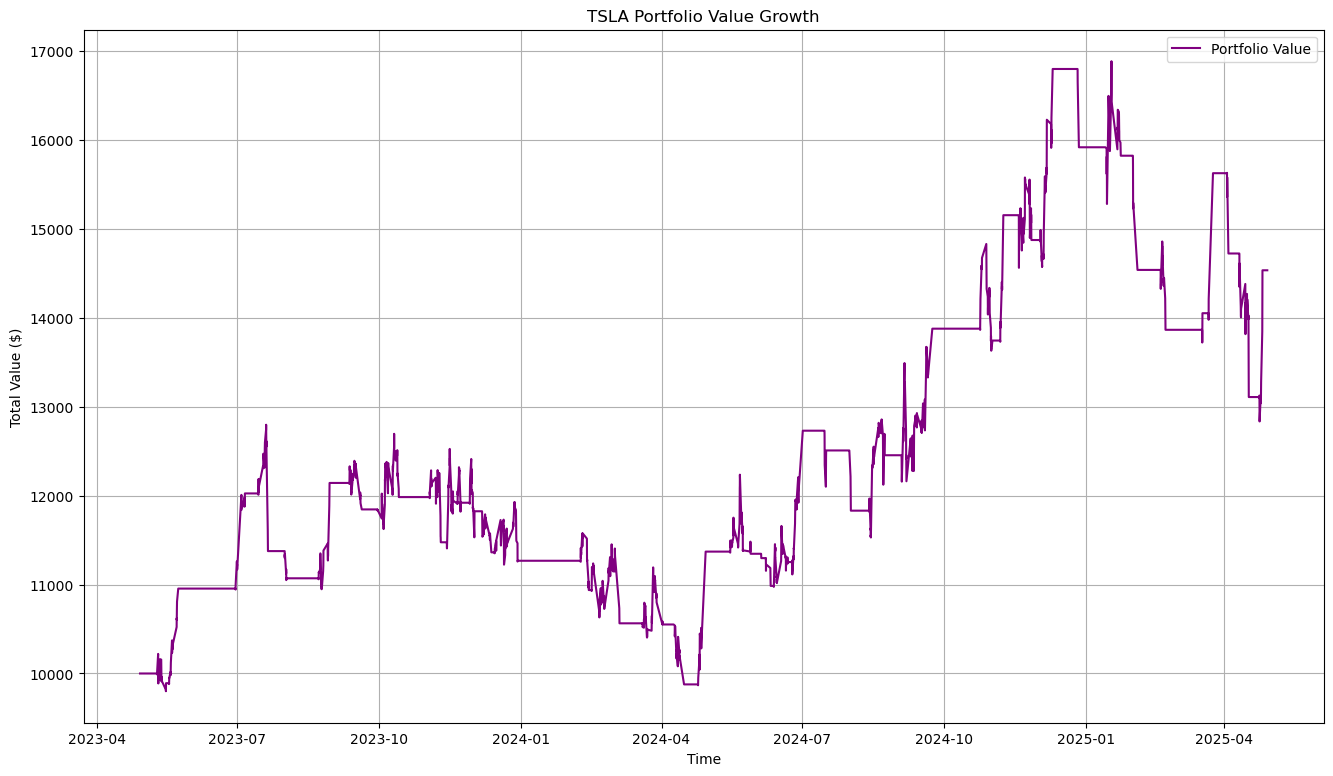

In [7]:
# Plotting everything
for stock in stocks:
    stock_df = stock_data[stock]
    # Portfolio Value Growth Chart
    plt.figure(figsize=(16,9))
    plt.plot(stock_df['Portfolio Value'], label='Portfolio Value', color='purple')
    plt.title(f'{stock} Portfolio Value Growth')
    plt.xlabel('Time')
    plt.ylabel('Total Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
# Calculate Final Metrics
for stock in stocks:
    stock_df = stock_data[stock]
    
    final_value = stock_df['Portfolio Value'].iloc[-1]
    total_profit = final_value - initial_balance
    cumulative_return = (total_profit / initial_balance) * 100

    stock_df['Returns'] = stock_df['Portfolio Value'].pct_change()
    mean_return = stock_df['Returns'].mean()
    std_return = stock_df['Returns'].std()

    sharpe_ratio = mean_return / std_return
    annualized_sharpe = sharpe_ratio * np.sqrt(252*6.5)

    print(f"\nResults for {stock}:")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Cumulative Return: {cumulative_return:.2f}%")
    print(f"Sharpe Ratio (Annualized): {annualized_sharpe:.2f}")



Results for AAPL:
Final Portfolio Value: $13408.42
Total Profit: $3408.42
Cumulative Return: 34.08%
Sharpe Ratio (Annualized): 0.91

Results for AMZN:
Final Portfolio Value: $11061.49
Total Profit: $1061.49
Cumulative Return: 10.61%
Sharpe Ratio (Annualized): 0.34

Results for GOOGL:
Final Portfolio Value: $9208.56
Total Profit: $-791.44
Cumulative Return: -7.91%
Sharpe Ratio (Annualized): -0.08

Results for TSLA:
Final Portfolio Value: $14533.17
Total Profit: $4533.17
Cumulative Return: 45.33%
Sharpe Ratio (Annualized): 0.75


In [ ]:
# doing final project with 2 years data

In [9]:
# Install yfinance (only run once if not installed)
!pip install yfinance


In [10]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# List of stocks
stocks = ['AAPL', 'AMZN', 'GOOGL', 'TSLA']

# Download 2 years of hourly stock data
data = yf.download(
    stocks,
    period='2y',        # Last 2 years
    interval='1h',      # 1-hour interval
    group_by='ticker'   # Group data by ticker
)

# Show what we downloaded
print(data.keys())


[*********************100%***********************]  4 of 4 completed

MultiIndex([( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume'),
            ( 'AMZN',   'Open'),
            ( 'AMZN',   'High'),
            ( 'AMZN',    'Low'),
            ( 'AMZN',  'Close'),
            ( 'AMZN', 'Volume'),
            ('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'TSLA',   'Open'),
            ( 'TSLA',   'High'),
            ( 'TSLA',    'Low'),
            ( 'TSLA',  'Close'),
            ( 'TSLA', 'Volume')],
           names=['Ticker', 'Price'])


In [12]:
# Function to generate Buy/Sell signals based on Moving Average Crossovers
def generate_signals(df, short_window=10, long_window=50):
    # Create Short-Term and Long-Term Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

    # Prepare columns for buy/sell points
    buy_signals = []
    sell_signals = []
    position = False  # False = not holding any stock

    # Loop through each row to decide Buy/Sell
    for i in range(len(df)):
        if df['SMA_Short'].iloc[i] > df['SMA_Long'].iloc[i]:  # Buy Condition
            if not position:
                buy_signals.append(df['Close'].iloc[i])
                sell_signals.append(np.nan)
                position = True
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        elif df['SMA_Short'].iloc[i] < df['SMA_Long'].iloc[i]:  # Sell Condition
            if position:
                sell_signals.append(df['Close'].iloc[i])
                buy_signals.append(np.nan)
                position = False
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    # Add buy/sell signals to the dataframe
    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    return df


In [ ]:
#Full Portfolio Simulation (with Risk Management)


In [13]:
# Set Trading Parameters
initial_balance = 10000         # Starting money
transaction_fee_rate = 0.001    # 0.1% transaction fee
stop_loss_pct = 0.05            # 5% stop-loss
take_profit_pct = 0.10          # 10% take-profit

# New dictionary to store processed stock data
stock_data = {}

# Loop over each stock separately
for stock in stocks:
    print(f"\nProcessing {stock}...")

    # Make a fresh copy of stock data
    stock_df = data[stock].copy()

    # Generate Buy/Sell signals
    stock_df = generate_signals(stock_df)

    # Initialize portfolio parameters
    balance = initial_balance
    holdings = 0
    buy_price = 0
    portfolio_values = []

    # Walk through each time step (each 1-hour candle)
    for i in range(len(stock_df)):
        price = stock_df['Close'].iloc[i]

        # If currently no stock, check if we should Buy
        if holdings == 0:
            if not np.isnan(stock_df['Buy'].iloc[i]):
                num_shares_to_buy = balance // (price * (1 + transaction_fee_rate))
                cost = num_shares_to_buy * price * (1 + transaction_fee_rate)
                if num_shares_to_buy > 0:
                    balance -= cost
                    holdings += num_shares_to_buy
                    buy_price = price

        # If holding stock, check if we should Sell, Stop-Loss, or Take-Profit
        else:
            if not np.isnan(stock_df['Sell'].iloc[i]):
                proceeds = holdings * price * (1 - transaction_fee_rate)
                balance += proceeds
                holdings = 0
                buy_price = 0
            elif buy_price > 0:
                loss_threshold = buy_price * (1 - stop_loss_pct)
                profit_threshold = buy_price * (1 + take_profit_pct)

                if price <= loss_threshold or price >= profit_threshold:
                    proceeds = holdings * price * (1 - transaction_fee_rate)
                    balance += proceeds
                    holdings = 0
                    buy_price = 0

        # Calculate total value at each point
        total_value = balance + (holdings * price)
        portfolio_values.append(total_value)

    # Save portfolio value into the dataframe
    stock_df['Portfolio Value'] = portfolio_values

    # Save the processed DataFrame into new dictionary
    stock_data[stock] = stock_df



Processing AAPL...

Processing AMZN...

Processing GOOGL...

Processing TSLA...


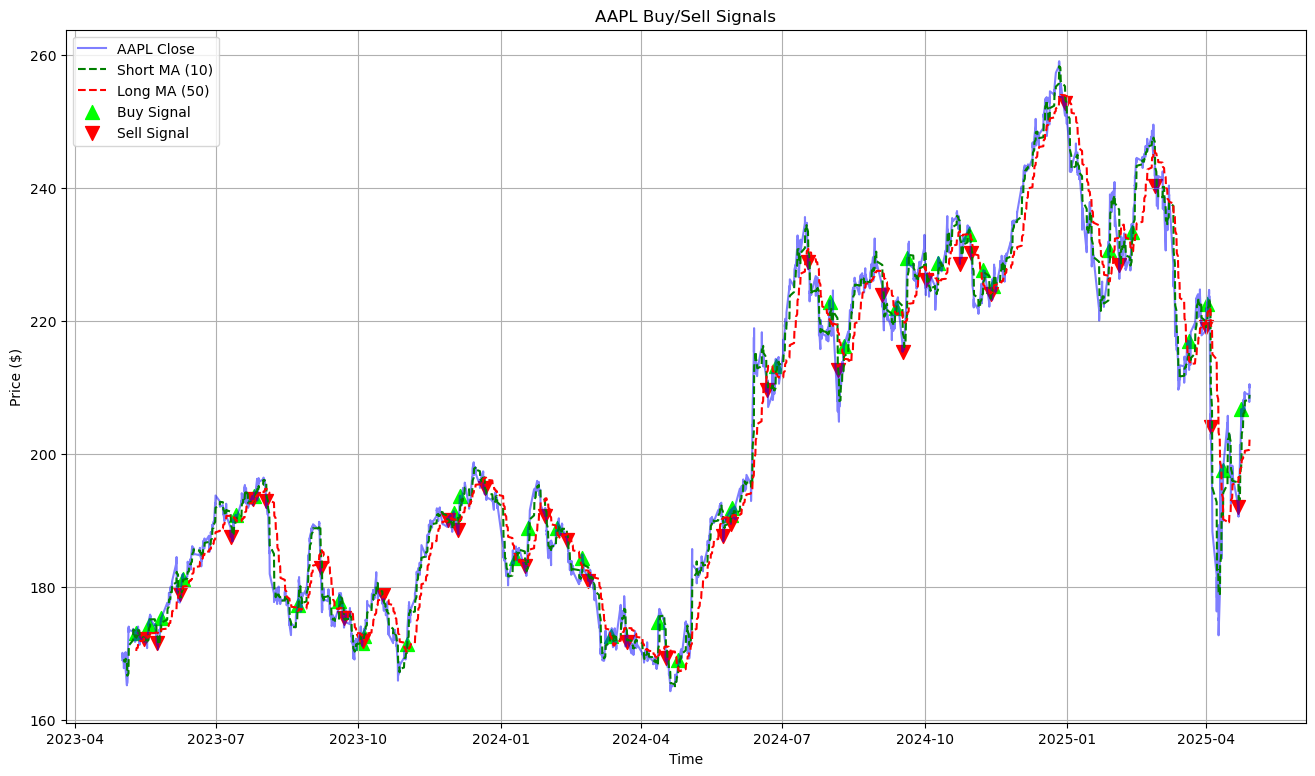

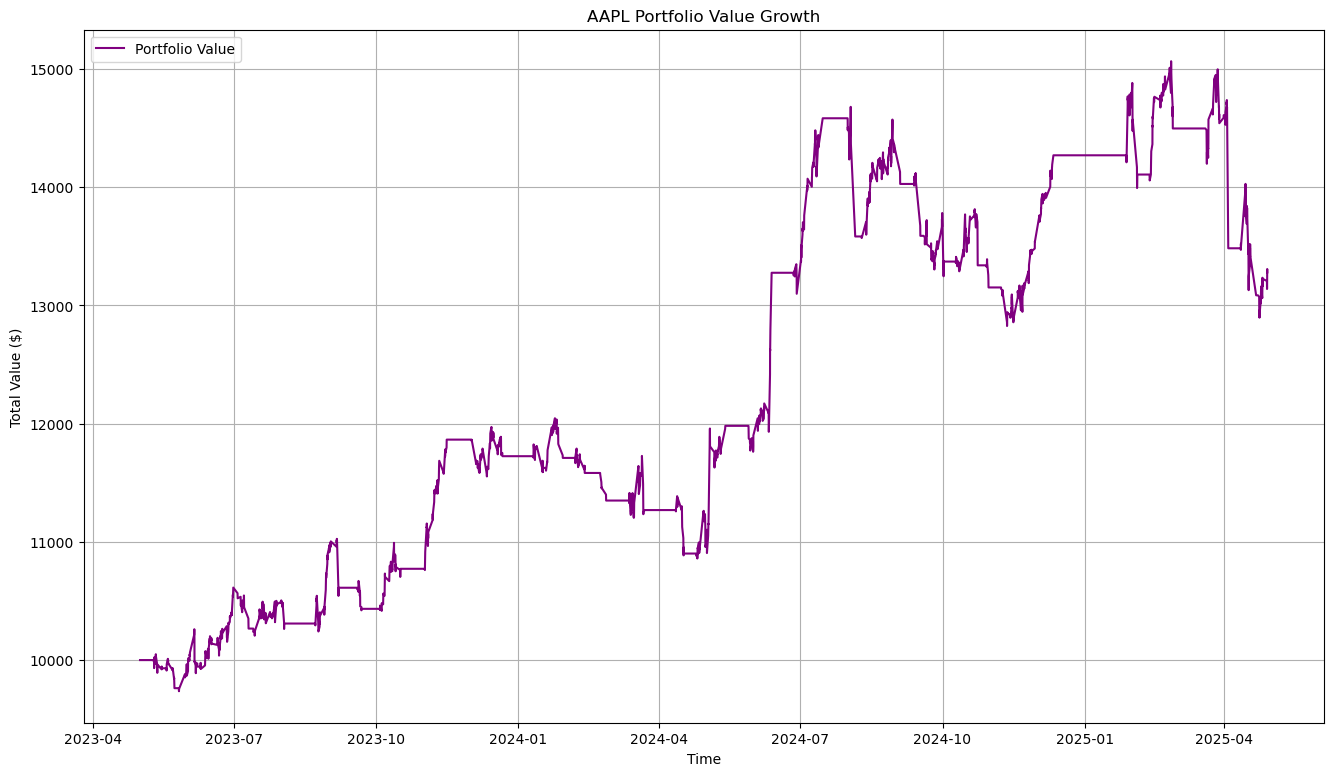

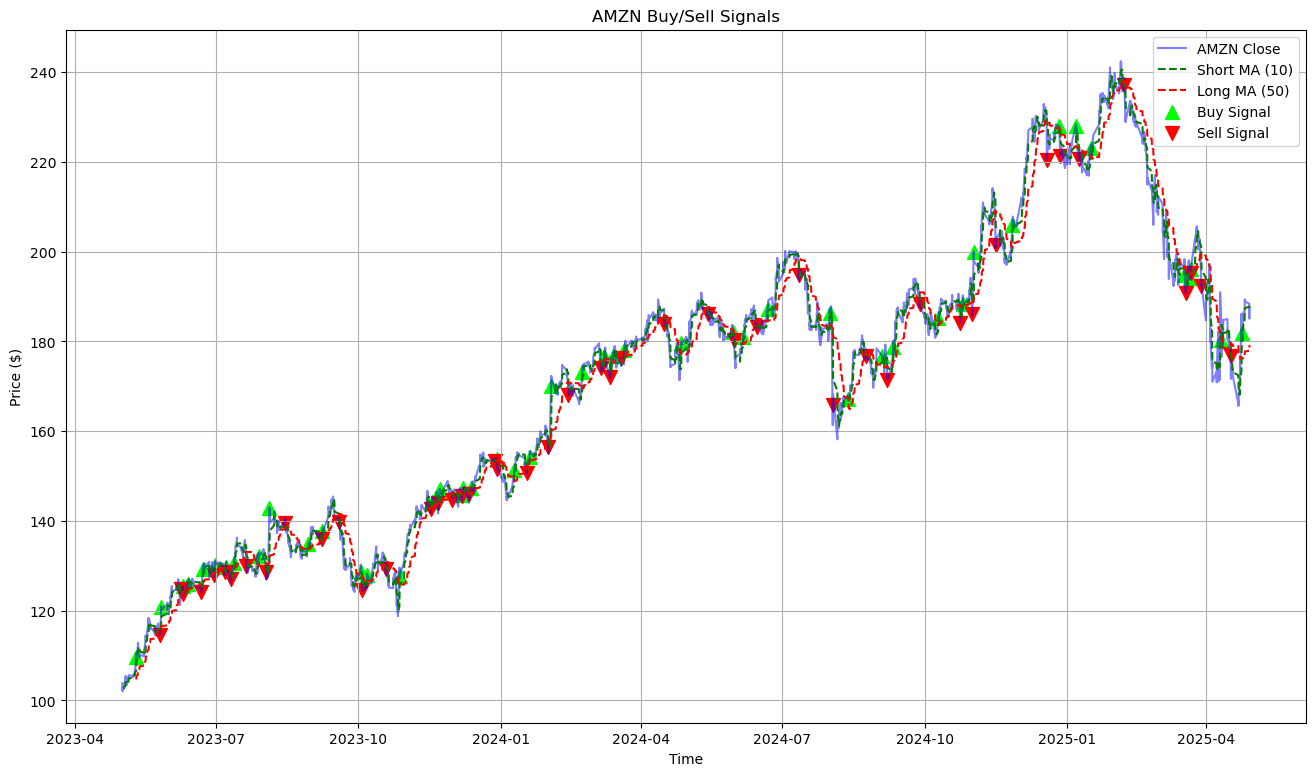

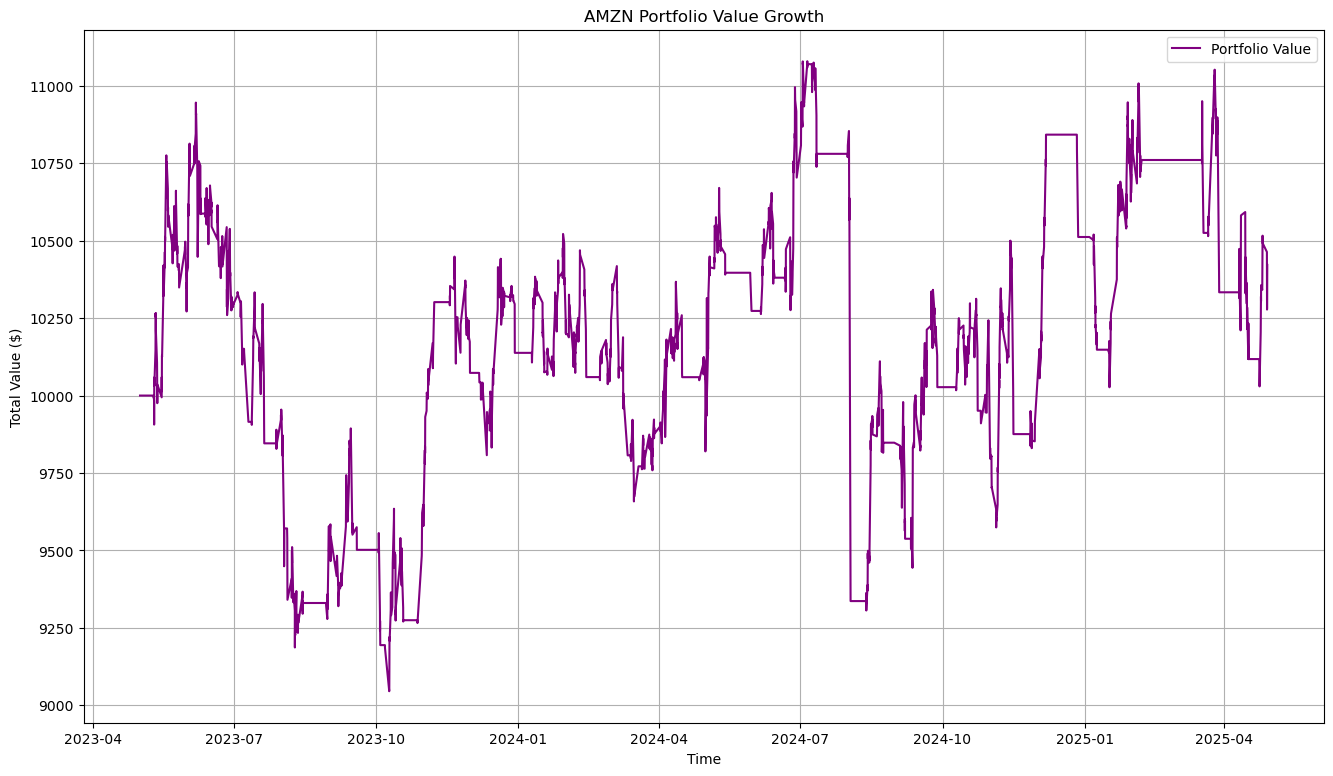

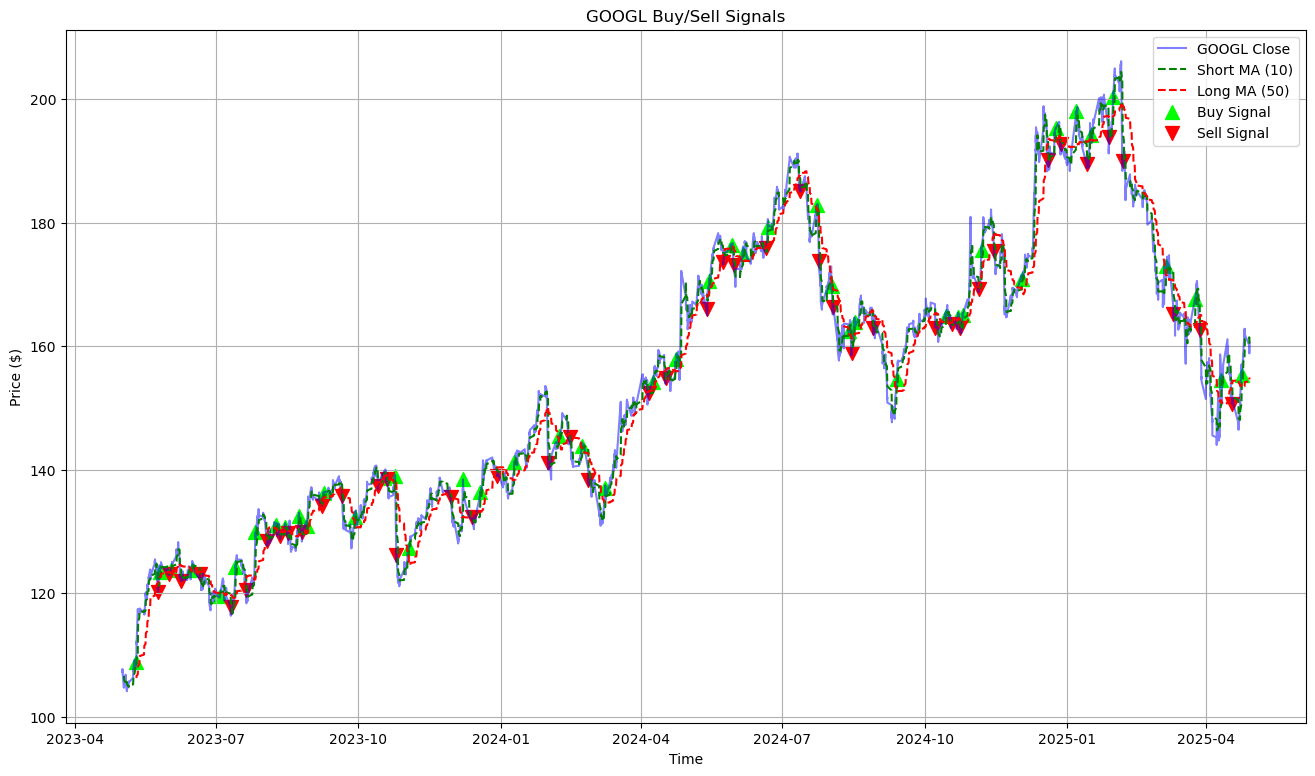

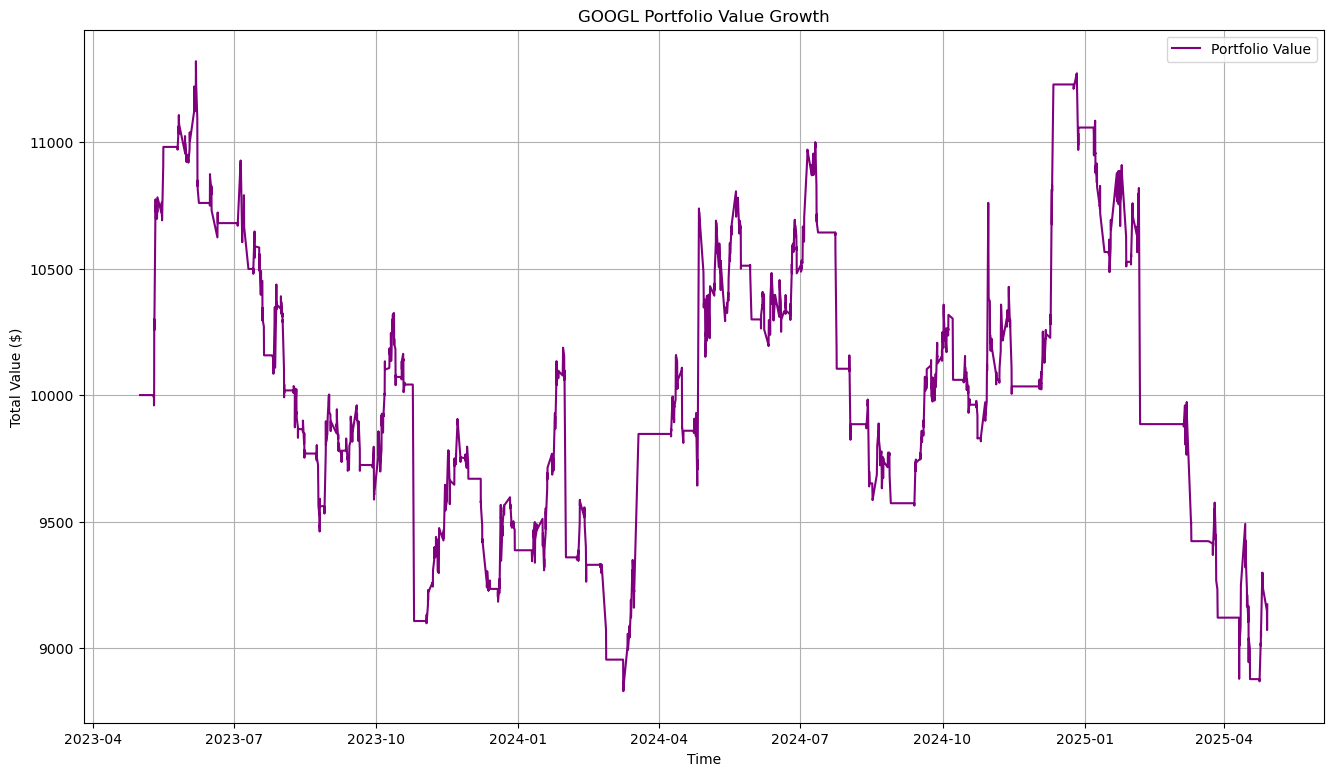

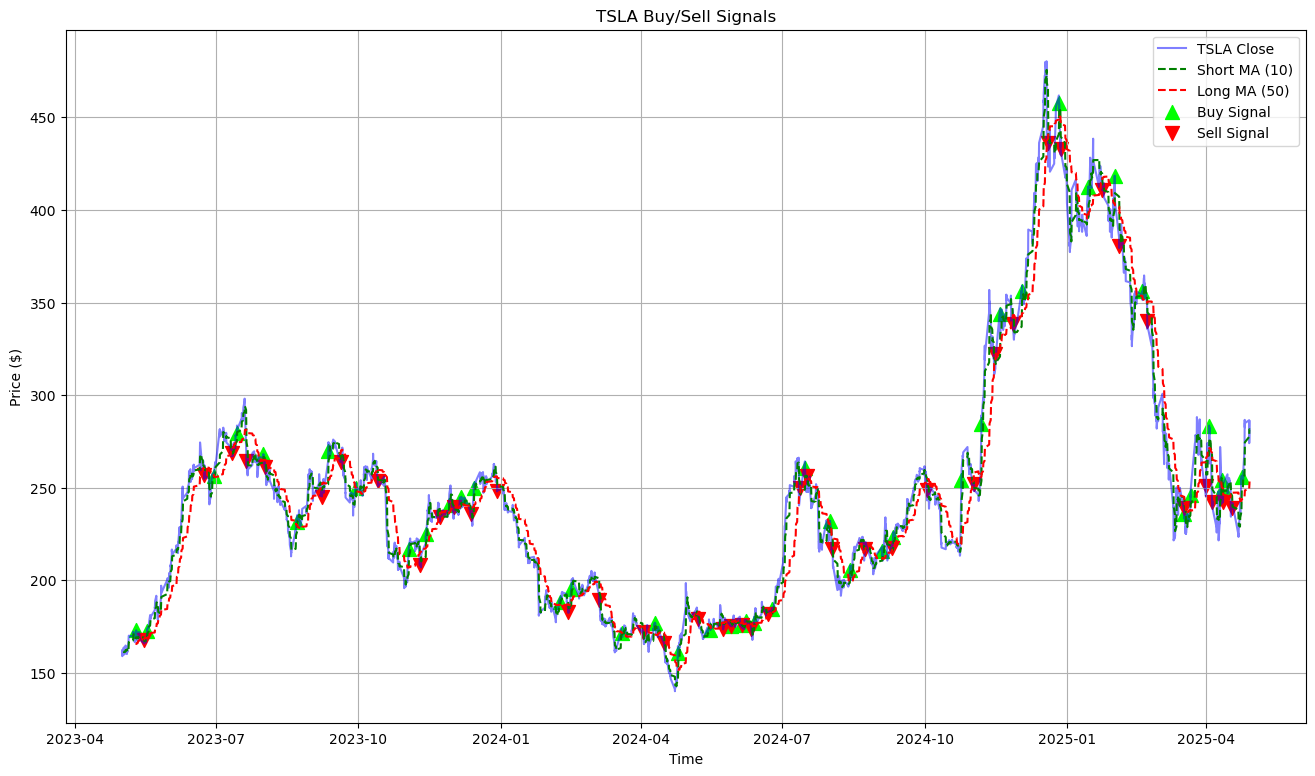

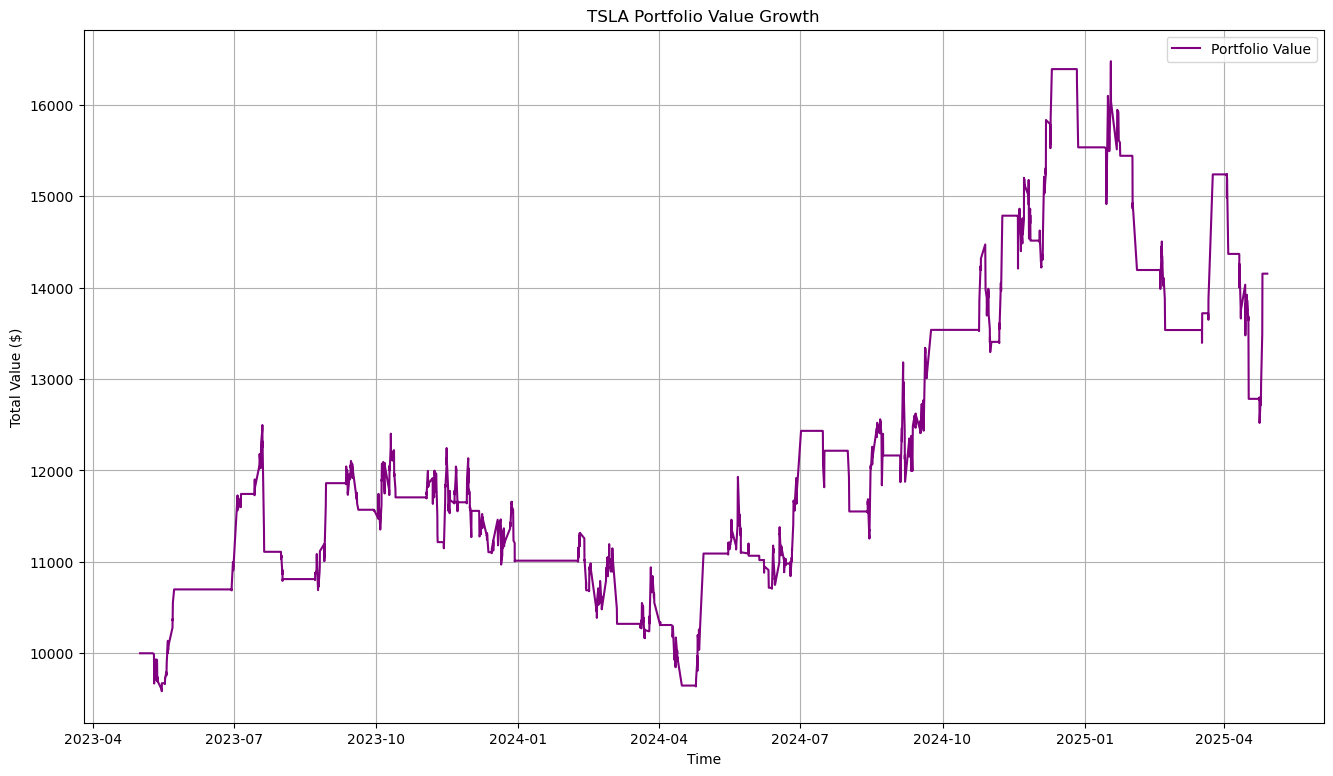

In [14]:
# Make sure this is at the top for normal static plotting
%matplotlib inline

# Plot Buy/Sell Signals and Portfolio Growth for each stock
for stock in stocks:
    stock_df = stock_data[stock]

    # 1️⃣ Plot Stock Price with Buy/Sell Signals
    plt.figure(figsize=(16,9))
    plt.plot(stock_df['Close'], label=f'{stock} Close', color='blue', alpha=0.5)
    plt.plot(stock_df['SMA_Short'], label='Short MA (10)', color='green', linestyle='--')
    plt.plot(stock_df['SMA_Long'], label='Long MA (50)', color='red', linestyle='--')
    plt.scatter(stock_df.index, stock_df['Buy'], label='Buy Signal', marker='^', color='lime', s=100)
    plt.scatter(stock_df.index, stock_df['Sell'], label='Sell Signal', marker='v', color='red', s=100)
    plt.title(f'{stock} Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid()
    plt.savefig(f"{stock}_Buy_Sell_Signals.png", dpi=300, bbox_inches='tight')  # <-- Save as PNG
    plt.show()

    # 2️⃣ Plot Portfolio Value Growth
    plt.figure(figsize=(16,9))
    plt.plot(stock_df['Portfolio Value'], label='Portfolio Value', color='purple')
    plt.title(f'{stock} Portfolio Value Growth')
    plt.xlabel('Time')
    plt.ylabel('Total Value ($)')
    plt.legend()
    plt.grid()
    plt.savefig(f"{stock}_Portfolio_Value_Growth.png", dpi=300, bbox_inches='tight')  # <-- Save as PNG
    plt.show()


In [15]:
# Calculate Final Metrics for each stock
for stock in stocks:
    stock_df = stock_data[stock]
    
    # Final portfolio value
    final_value = stock_df['Portfolio Value'].iloc[-1]
    total_profit = final_value - initial_balance
    cumulative_return = (total_profit / initial_balance) * 100

    # Calculate returns for Sharpe Ratio
    stock_df['Returns'] = stock_df['Portfolio Value'].pct_change()

    mean_return = stock_df['Returns'].mean()
    std_return = stock_df['Returns'].std()

    # Sharpe Ratio (Non-Annualized)
    sharpe_ratio = mean_return / std_return

    # Sharpe Ratio (Annualized)
    annualized_sharpe = sharpe_ratio * np.sqrt(252*6.5)  # 252 trading days × 6.5 hours/day

    # Print results cleanly
    print(f"\n📈 Final Results for {stock}:")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Cumulative Return: {cumulative_return:.2f}%")
    print(f"Sharpe Ratio (Non-Annualized): {sharpe_ratio:.2f}")
    print(f"Sharpe Ratio (Annualized): {annualized_sharpe:.2f}")



📈 Final Results for AAPL:
Final Portfolio Value: $13279.64
Total Profit: $3279.64
Cumulative Return: 32.80%
Sharpe Ratio (Non-Annualized): 0.02
Sharpe Ratio (Annualized): 0.88

📈 Final Results for AMZN:
Final Portfolio Value: $10421.74
Total Profit: $421.74
Cumulative Return: 4.22%
Sharpe Ratio (Non-Annualized): 0.00
Sharpe Ratio (Annualized): 0.20

📈 Final Results for GOOGL:
Final Portfolio Value: $9172.51
Total Profit: $-827.49
Cumulative Return: -8.27%
Sharpe Ratio (Non-Annualized): -0.00
Sharpe Ratio (Annualized): -0.09

📈 Final Results for TSLA:
Final Portfolio Value: $14152.17
Total Profit: $4152.17
Cumulative Return: 41.52%
Sharpe Ratio (Non-Annualized): 0.02
Sharpe Ratio (Annualized): 0.70


In [ ]:
#add trasaction costs
